# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (Inria), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Load the dataset using pandas

The training and testing data are located in the folder `data`. They are compressed `csv` file (i.e. `csv.bz2`). We can load the dataset using pandas.

In [3]:
data = pd.read_csv(os.path.join("data", "train.csv.bz2"))

<IPython.core.display.Javascript object>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   log_PAX           8902 non-null   float64
 5   std_wtd           8902 non-null   float64
dtypes: float64(3), object(3)
memory usage: 417.4+ KB


<IPython.core.display.Javascript object>

So as stated earlier, the column `log_PAX` is the target for our regression problem. The other columns are the features which will be used for our prediction problem. If we focus on the data type of the column, we can see that `DateOfDeparture`, `Departure`, and `Arrival` are of `object` dtype, meaning they are strings.

In [5]:
data[["DateOfDeparture", "Departure", "Arrival"]].head()

,DateOfDeparture,Departure,Arrival
0,2012-06-19,ORD,DFW
1,2012-09-10,LAS,DEN
2,2012-10-05,DEN,LAX
3,2011-10-09,ATL,ORD
4,2012-02-21,DEN,SFO


<IPython.core.display.Javascript object>

While it makes `Departure` and `Arrival` are the code of the airport, we see that the `DateOfDeparture` should be a date instead of string. We can use pandas to convert this data.

In [6]:
data.loc[:, "DateOfDeparture"] = pd.to_datetime(data.loc[:, "DateOfDeparture"])

<IPython.core.display.Javascript object>

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateOfDeparture   8902 non-null   datetime64[ns]
 1   Departure         8902 non-null   object        
 2   Arrival           8902 non-null   object        
 3   WeeksToDeparture  8902 non-null   float64       
 4   log_PAX           8902 non-null   float64       
 5   std_wtd           8902 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 417.4+ KB


<IPython.core.display.Javascript object>

When you will create a submission, `ramp-workflow` will load the data for you and split into a data matrix `X` and a target vector `y`. It will also take care about splitting the data into a training and testing set. These utilities are available in the module `problem.py` which we will load.

In [8]:
import problem

<IPython.core.display.Javascript object>

The function `get_train_data()` loads the training data and returns a pandas dataframe `X` and a numpy vector `y`.

In [9]:
X, y = problem.get_train_data()

<IPython.core.display.Javascript object>

In [10]:
type(X)

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>

In [11]:
type(y)

numpy.ndarray

<IPython.core.display.Javascript object>

We can check the information of the data `X`

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   std_wtd           8902 non-null   float64
dtypes: float64(2), object(3)
memory usage: 347.9+ KB


<IPython.core.display.Javascript object>

In [13]:
X

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159
...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967
8898,2012-09-25,DFW,ORD,12.772727,10.641034
8899,2012-01-19,SFO,LAS,11.047619,7.908705
8900,2013-02-03,ORD,PHL,6.076923,4.030334


<IPython.core.display.Javascript object>

In [14]:
y

array([12.33129622, 10.77518151, 11.08317675, ..., 10.508746  ,
       10.17404162,  9.20267425])

<IPython.core.display.Javascript object>

Thus, this is important to see that `ramp-workflow` does not convert the `DateOfDeparture` column into a `datetime` format. Thus, keep in mind that you might need to make a conversion when prototyping your machine learning pipeline later on. Let's check some statistics regarding our dataset.

In [15]:
print(min(X["DateOfDeparture"]))
print(max(X["DateOfDeparture"]))

2011-09-01
2013-03-05


<IPython.core.display.Javascript object>

In [16]:
X["Departure"].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

<IPython.core.display.Javascript object>

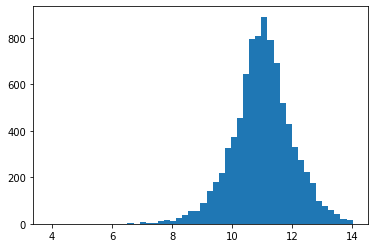

<IPython.core.display.Javascript object>

In [17]:
_ = plt.hist(y, bins=50)

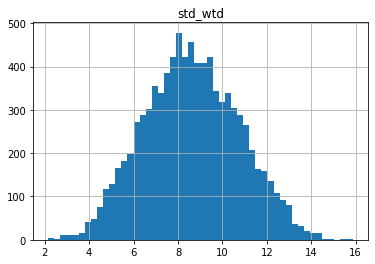

<IPython.core.display.Javascript object>

In [18]:
_ = X.hist("std_wtd", bins=50)

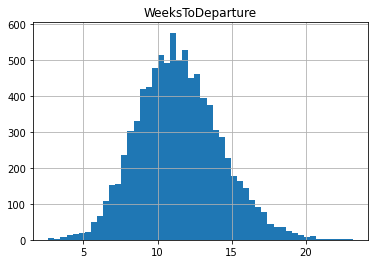

<IPython.core.display.Javascript object>

In [19]:
_ = X.hist("WeeksToDeparture", bins=50)

In [20]:
X.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


<IPython.core.display.Javascript object>

In [21]:
X.shape

(8902, 5)

<IPython.core.display.Javascript object>

In [22]:
print(y.mean())
print(y.std())

10.99904767212102
0.9938894125318564


<IPython.core.display.Javascript object>

## Preprocessing dates

Getting dates into numerical columns is a common operation when time series data is analyzed with non-parametric predictors. The code below makes the following transformations:

- numerical columns for year (2011-2012), month (1-12), day of the month (1-31), day of the week (0-6), and week of the year (1-52)
- number of days since 1970-01-01

In [23]:
# Make a copy of the original data to avoid writing on the original data
X_encoded = X.copy()

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded["DateOfDeparture"] = pd.to_datetime(X_encoded["DateOfDeparture"])
X_encoded["year"] = X_encoded["DateOfDeparture"].dt.year
X_encoded["month"] = X_encoded["DateOfDeparture"].dt.month
X_encoded["day"] = X_encoded["DateOfDeparture"].dt.day
X_encoded["weekday"] = X_encoded["DateOfDeparture"].dt.weekday
X_encoded["week"] = X_encoded["DateOfDeparture"].dt.week
X_encoded["n_days"] = X_encoded["DateOfDeparture"].apply(
    lambda date: (date - pd.to_datetime("1970-01-01")).days
)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

In [24]:
X_encoded.tail(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days
8897,2011-10-02,DTW,ATL,9.263158,7.316967,2011,10,2,6,39,15249
8898,2012-09-25,DFW,ORD,12.772727,10.641034,2012,9,25,1,39,15608
8899,2012-01-19,SFO,LAS,11.047619,7.908705,2012,1,19,3,3,15358
8900,2013-02-03,ORD,PHL,6.076923,4.030334,2013,2,3,6,5,15739
8901,2011-11-26,DTW,ATL,9.526316,6.167733,2011,11,26,5,47,15304


<IPython.core.display.Javascript object>

We will perform all preprocessing steps within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) which chains together tranformation and estimator steps. This offers offers convenience and safety (help avoid leaking statistics from your test data into the trained model in cross-validation) and the whole pipeline can be evaluated with `cross_val_score`.

To perform the above encoding within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) we will a function and using `FunctionTransformer` to make it compatible with scikit-learn API.

In [25]:
from sklearn.preprocessing import FunctionTransformer


def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, "DateOfDeparture"] = pd.to_datetime(X_encoded["DateOfDeparture"])
    # Encode the DateOfDeparture
    X_encoded.loc[:, "year"] = X_encoded["DateOfDeparture"].dt.year
    X_encoded.loc[:, "month"] = X_encoded["DateOfDeparture"].dt.month
    X_encoded.loc[:, "day"] = X_encoded["DateOfDeparture"].dt.day
    X_encoded.loc[:, "weekday"] = X_encoded["DateOfDeparture"].dt.weekday
    X_encoded.loc[:, "week"] = X_encoded["DateOfDeparture"].dt.week
    X_encoded.loc[:, "n_days"] = X_encoded["DateOfDeparture"].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    # Once we did the encoding, we will not need DateOfDeparture
    return X_encoded.drop(columns=["DateOfDeparture"])


date_encoder = FunctionTransformer(_encode_dates)

<IPython.core.display.Javascript object>

In [26]:
date_encoder.fit_transform(X).head()

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days
0,ORD,DFW,12.875000,9.812647,2012,6,19,1,25,15510
1,LAS,DEN,14.285714,9.466734,2012,9,10,0,37,15593
2,DEN,LAX,10.863636,9.035883,2012,10,5,4,40,15618
3,ATL,ORD,11.480000,7.990202,2011,10,9,6,40,15256
4,DEN,SFO,11.450000,9.517159,2012,2,21,1,8,15391


<IPython.core.display.Javascript object>

## Random Forests

Tree-based algorithms requires less complex preprocessing than linear-models. We will first present a machine-learning pipeline where we will use a random forest. In this pipeline, we will need to:

- encode the date to numerical values (as presented in the section above);
- oridinal encode the other categorical values to get numerical number;
- keep numerical features as they are.

Thus, we want to perform three different processes on different columns of the original data `X`. In scikit-learn, we can use [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) to perform such processing.

In [27]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["DateOfDeparture"]

categorical_encoder = OrdinalEncoder()
categorical_cols = ["Arrival", "Departure"]

preprocessor = make_column_transformer(
    (date_encoder, date_cols),
    (categorical_encoder, categorical_cols),
    remainder="passthrough",  # passthrough numerical columns as they are
)

<IPython.core.display.Javascript object>

We can combine our preprocessor with an estimator (`RandomForestRegressor` in this case), allowing us to make predictions.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

n_estimators = 10
max_depth = 10
max_features = 10

regressor = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features
)

pipeline = make_pipeline(preprocessor, regressor)

<IPython.core.display.Javascript object>

We can cross-validate our `pipeline` using `cross_val_score`. Below we will have specified `cv=5` meaning KFold cross-valdiation splitting will be used, with 8 folds. The mean squared error regression loss is calculated for each split. The output `score` will be an array of 5 scores from each KFold. The score mean and standard deviation of the 5 scores is printed at the end.

In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print(f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaco

RMSE: 0.6396 +/- 0.0179


C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


<IPython.core.display.Javascript object>

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    "rf__n_estimators": [5, 10],
    "rf__max_depth": [1, 5, 10],
    "rf__max_features": [2, 5, 7, 10],
}  # Create a based model

pipeline = Pipeline([("prep", preprocessor), ("rf", RandomForestRegressor()),])

CV = GridSearchCV(
    pipeline, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=5,
)
CV.fit(X, y)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function _encode_dates at 0x000001C600A2EB88>),
                                                                         ['DateOfDeparture']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['Arrival',
                                                                          'Departure'])])),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 5, 10],
 

<IPython.core.display.Javascript object>

In [31]:
print(CV.best_estimator_)
rmse_scores = np.sqrt(-CV.best_score_)
rmse_scores

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer',
                                                  FunctionTransformer(func=<function _encode_dates at 0x000001C600A2EB88>),
                                                  ['DateOfDeparture']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Arrival', 'Departure'])])),
                ('rf',
                 RandomForestRegressor(max_depth=10, max_features=10,
                                       n_estimators=10))])


0.6872115483994884

<IPython.core.display.Javascript object>

## Linear regressor

When dealing with a linear model, we need to one-hot encode categorical variables instead of ordinal encoding and standardize numerical variables. Thus we will:

- encode the date;
- then, one-hot encode all categorical columns, including the encoded date as well;
- standardize the numerical columns.

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["DateOfDeparture"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = [
    "Arrival",
    "Departure",
    "year",
    "month",
    "day",
    "weekday",
    "week",
    "n_days",
]

numerical_scaler = StandardScaler()
numerical_cols = ["WeeksToDeparture", "std_wtd"]

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols), (numerical_scaler, numerical_cols)
)

<IPython.core.display.Javascript object>

We can now combine our `preprocessor` with the `LinearRegression` estimator in a `Pipeline`:

In [33]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

pipeline = make_pipeline(date_encoder, preprocessor, regressor)

<IPython.core.display.Javascript object>

And we can evaluate our linear-model pipeline:

In [34]:
scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print(f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\benja\Anaco

RMSE: 0.6117 +/- 0.0149


C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


<IPython.core.display.Javascript object>

# Merging external data

In [35]:
X

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159
...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967
8898,2012-09-25,DFW,ORD,12.772727,10.641034
8899,2012-01-19,SFO,LAS,11.047619,7.908705
8900,2013-02-03,ORD,PHL,6.076923,4.030334


<IPython.core.display.Javascript object>

In [ ]:
holidays = pd.read_csv("Holidays.csv", sep=";")
holidays

In [ ]:
airports = pd.read_csv('Airports_data.csv', sep=';')
airports

In [ ]:
monthly_pax = pd.read_csv('MonthlyDomesticPAX.csv', sep=';')
monthly_pax

In [ ]:
X['Holiday']=0
for date in X['DateOfDeparture']:
    for holiday in holidays:
        if date == holiday:
            X['Holiday']=1

In [ ]:
X

The objective in this RAMP data challenge is to find good data that can be correlated to flight traffic. We will use some weather data (saved in `submissions/starting_kit`) to provide an example of how to merge external data in a scikit-learn pipeline.

Your external data will need to be included in your submissions folder - see [RAMP submissions](#RAMP-submissions) for more details.

First we will define a function that merges the external data to our feature data.

In [114]:
# when submitting a kit, the `__file__` variable will corresponds to the
# path to `estimator.py`. However, this variable is not defined in the
# notebook and thus we must define the `__file__` variable to imitate
# how a submission `.py` would work.
__file__ = os.path.join("submissions", "use_external_data", "estimator.py")
filepath = os.path.join(os.path.dirname(__file__), "process_airports_mean_weekday.csv")
filepath

'submissions\\use_external_data\\process_airports_mean_weekday.csv'

<IPython.core.display.Javascript object>

In [117]:
pd.read_csv(filepath).head(30)

,Origin_airport,Destination_airport,weekday,Passengers,Seats,Flights,Distance,Origin_population,Destination_population
0,ATL,ATL,0,60.000000,94.000000,1.000000,0.0,5267527,5267527
1,ATL,ATL,1,10.857143,86.857143,0.714286,0.0,5475213,5475213
2,ATL,ATL,2,46.285714,141.857143,1.428571,0.0,5475213,5475213
3,ATL,ATL,3,100.250000,162.500000,1.750000,0.0,5385586,5385586
4,ATL,ATL,4,19.857143,175.428571,1.428571,0.0,5475213,5475213
5,ATL,ATL,5,23.000000,180.600000,1.400000,0.0,5475213,5475213
6,ATL,ATL,6,11.714286,31.428571,0.857143,0.0,5475213,5475213
7,ATL,BOS,0,8324.300000,10113.820000,68.040000,946.0,5475213,9177360
8,ATL,BOS,1,7565.269231,9565.961538,63.538462,946.0,5475213,9177360
9,ATL,BOS,2,8227.566667,9865.383333,65.650000,946.0,5475213,9177360


<IPython.core.display.Javascript object>

In [127]:
def _merge_airport_data(X):
    filepath = os.path.join(
        os.path.dirname(__file__), "process_airports_mean_weekday.csv"
    )

    X = X.copy()  # to avoid raising SettingOnCopyWarning
    # Make sure that DateOfDeparture is of dtype datetime

    X["weekday"] = pd.to_datetime(X["DateOfDeparture"]).dt.weekday

    data_airport = pd.read_csv(filepath)

    X_airport = data_airport.drop(["Flights", "Seats"], axis=1)

    X_airport = X_airport.rename(
        columns={"Origin_airport": "Departure", "Destination_airport": "Arrival",}
    )
    X_merged = pd.merge(
        X, X_airport, how="left", on=["Departure", "Arrival", "weekday"], sort=False
    )
    X_merged = X_merged.drop(["weekday"], axis=1)
    X_merged[["Passengers", "Seats", "Flights"]] = df[
        ["Passengers", "Seats", "Flights"]
    ].fillna(0)
    X_merged = X_merged.fillna(
        (
            X_merged[
                (X_merged["Departure"] == "DEN") & (X_merged["Arrival"] == "SEA")
            ].mean()
        )
    )
    return X_merged


data_merger = FunctionTransformer(_merge_airport_data)

<IPython.core.display.Javascript object>

Double check that our function works:

In [138]:
data_merger.fit_transform(X).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Passengers,Distance,Origin_population,Destination_population,Seats,Flights
0,2012-06-19,ORD,DFW,12.875000,9.812647,5740.186047,802.0,19161134.0,12895230.0,7147.085271,55.209302
1,2012-09-10,LAS,DEN,14.285714,9.466734,1411.684211,604.0,1902834.0,626227.0,1726.263158,17.947368
2,2012-10-05,DEN,LAX,10.863636,9.035883,1896.333333,833.0,626227.0,25749594.0,2458.000000,45.200000
3,2011-10-09,ATL,ORD,11.480000,7.990202,3372.422360,606.0,5475213.0,19161134.0,4330.049689,37.677019
4,2012-02-21,DEN,SFO,11.450000,9.517159,964.133333,963.0,626227.0,8635706.0,1374.533333,24.533333


<IPython.core.display.Javascript object>

In [51]:
X

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159
...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967
8898,2012-09-25,DFW,ORD,12.772727,10.641034
8899,2012-01-19,SFO,LAS,11.047619,7.908705
8900,2013-02-03,ORD,PHL,6.076923,4.030334


<IPython.core.display.Javascript object>

Use `FunctionTransformer` to make our function compatible with scikit-learn API:

We can now assemble our pipeline using the same `data_merger` and `preprocessor` as above:

In [133]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["DateOfDeparture"]

categorical_encoder = OrdinalEncoder()
categorical_cols = ["Arrival", "Departure"]

preprocessor = make_column_transformer(
    (date_encoder, date_cols),
    (categorical_encoder, categorical_cols),
    remainder="passthrough",  # passthrough numerical columns as they are
)

<IPython.core.display.Javascript object>

In [148]:
n_estimators = 100
max_depth = 20
max_features = 3

regressor = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features
)

pipeline = make_pipeline(data_merger, preprocessor, regressor)
scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print(f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been dep

RMSE: 0.5566 +/- 0.0907


<IPython.core.display.Javascript object>

In [144]:
from sklearn import linear_model

regressor = linear_model.Lasso(alpha=1)
pipeline = make_pipeline(data_merger, preprocessor, regressor)
scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print(f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been dep

RMSE: 0.9417 +/- 0.0366


submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


<IPython.core.display.Javascript object>

## Feature importances

We can check the feature importances using the function [`sklearn.inspection.permutation_importances`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). Since the first step of our pipeline adds the new external feature `Max TemperatureC`, we want to apply this transformation after adding `Max TemperatureC`, to check the importances of all features. Indeed, we can perform `sklearn.inspection.permutation_importances` at any stage of the pipeline, as we will see later on.


The code below:

* performs `transform` on the first step of the pipeline (`pipeline[0]`) producing the transformed train (`X_train_augmented`) and test (`X_test_augmented`) data
* the transformed data is used to fit the pipeline from the second step onwards

Note that pipelines can be sliced. `pipeline[0]` obtains the first step (tuple) of the pipeline. You can further slice to obtain either the transformer/estimator (first item in each tuple) or column list (second item within each tuple) inside each tuple. For example `pipeline[0][0]` obtains the transformer of the first step of the pipeline (first item of the first tuple).

In [141]:
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _merge_airport_data at 0x000001C60223F678>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer',
                                                  FunctionTransformer(func=<function _encode_dates at 0x000001C600A2EB88>),
                                                  ['DateOfDeparture']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Arrival', 'Departure'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, max_features=10))])

<IPython.core.display.Javascript object>

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

merger = pipeline[0]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipeline[1:]
predictor.fit(X_train_augmented, y_train).score(X_test_augmented, y_test)

submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


0.7715479403337724

<IPython.core.display.Javascript object>

With the fitted pipeline, we can now use `permutation_importance` to calculate feature importances:

In [150]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=10
)

submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been dep

submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been dep

submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
submissions\use_external_data\estimator.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been dep

<IPython.core.display.Javascript object>

Here, we plot the permutation importance using the training set. The higher the value, more important the feature is.

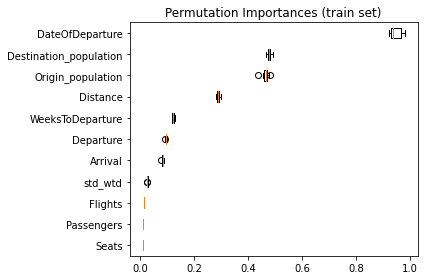

<IPython.core.display.Javascript object>

In [137]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=X_train_augmented.columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can replicate the same processing on the test set and see if we can observe the same trend.

In [47]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been 

submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been 

submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been 

<IPython.core.display.Javascript object>

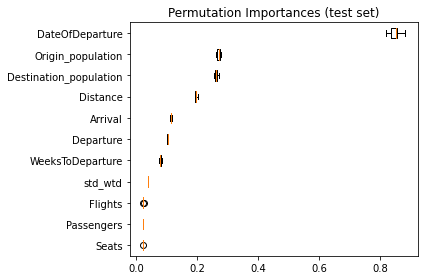

<IPython.core.display.Javascript object>

In [151]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=X_test_augmented.columns[sorted_idx],
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

With the current version of scikit-learn, it is not handy but still possible to check the feature importances at the latest stage of the pipeline (once all features have been preprocessed).

The difficult part is to get the name of the features.

In [49]:
preprocessor = pipeline[:-1]
predictor = pipeline[-1]

X_train_augmented = preprocessor.transform(X_train)
X_test_augmented = preprocessor.transform(X_test)

submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")
submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")


<IPython.core.display.Javascript object>

Let's find out the feature names (in the future, scikit-learn will provide a `get_feature_names` function to handle this case).

In [50]:
date_cols_name = date_encoder.transform(X_train[date_cols]).columns.tolist()
categorical_cols_name = categorical_cols
numerical_cols_name = (
    pipeline[0].transform(X_train).columns[pipeline[1].transformers_[-1][-1]].tolist()
)

submissions\use_external_data\estimator.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_airport = pd.read_csv(filepath, sep=";")


<IPython.core.display.Javascript object>

In [51]:
feature_names = np.array(date_cols_name + categorical_cols_name + numerical_cols_name)
feature_names

array(['year', 'month', 'day', 'weekday', 'week', 'n_days', 'Arrival',
       'Departure', 'WeeksToDeparture', 'std_wtd', 'PopulationDeparture',
       'NbPassengersDeparture', 'AverageFlightFareDeparture',
       'PopulationArrival', 'NbPassengersArrival',
       'AverageFlightFareArrival'], dtype='<U26')

<IPython.core.display.Javascript object>

We can repeat the previous processing at this finer grain, where the transformed date columns are included.

In [52]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=10
)

<IPython.core.display.Javascript object>

Here, we plot the permutation importance using the training set. Basically, higher the value, more important is the feature.

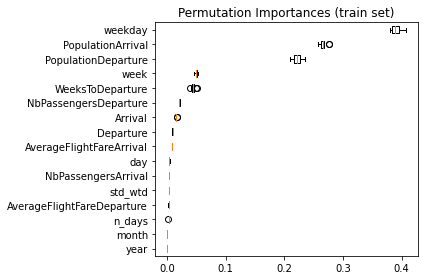

<IPython.core.display.Javascript object>

In [53]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can replicate the same processing on the test set and see if we can observe the same trend.

In [54]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

<IPython.core.display.Javascript object>

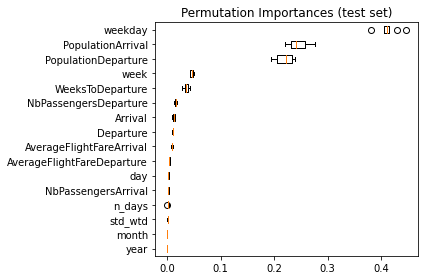

<IPython.core.display.Javascript object>

In [55]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).

In [ ]:
!ramp-test --submission use_external_data

In [1]:
!pip install -U -r requirements.txt  --user

Requirement already up-to-date: ramp-workflow in c:\users\benja\anaconda3\lib\site-packages (from -r requirements.txt (line 1)) (0.3.3)
Requirement already up-to-date: numpy in c:\users\benja\anaconda3\lib\site-packages (from -r requirements.txt (line 2)) (1.19.4)
Requirement already up-to-date: scikit-learn>=0.22 in c:\users\benja\anaconda3\lib\site-packages (from -r requirements.txt (line 3)) (0.23.2)
Requirement already up-to-date: joblib in c:\users\benja\anaconda3\lib\site-packages (from -r requirements.txt (line 4)) (0.17.0)
Requirement already up-to-date: cloudpickle in c:\users\benja\anaconda3\lib\site-packages (from -r requirements.txt (line 5)) (1.6.0)
Requirement already up-to-date: pandas in c:\users\benja\anaconda3\lib\site-packages (from -r requirements.txt (line 6)) (1.1.4)
  Using cached https://files.pythonhosted.org/packages/24/02/202982cbc4ab7a5a87c7f8d16e51d464016af742d5fb2d2b6b23116caec5/matplotlib-3.3.3-cp37-cp37m-win_amd64.whl
Requirement already up-to-date: holi